Academic Honesty Statement

> *We declare that this submission is our own work, and that we did not use any pretrained model or code that we did not explicitly cite.*

# I. Introduction

### 1.1. Problem Statement
The objective of this project is to design, train, and evaluate a Deep Learning model capable of solving a **Multi-task Learning** problem. We are provided with a custom dataset containing **3,000 samples**. Each sample consists of a `(32, 32)` input matrix (interpreted as a grayscale image) associated with three distinct targets:

* **Target A:** Classification (10 classes, integers 0-9).
* **Target B:** Classification (32 classes, integers 0-31).
* **Target C:** Regression (Real value in range $[0, 1]$).

### 1.2. Methodology
Our goal is to build a **single unified Neural Network** (likely based on CNN) that predicts all three components simultaneously. This approach allows the model to learn shared feature representations from the input images before branching out to specific tasks.

The notebook is structured as follows:
1.  **Data Inspection:** Analyzing shapes and distributions.
2.  **Model Design:** Creating a multi-head architecture.
3.  **Experiments:** Tuning hyperparameters (Learning Rate).
4.  **Evaluation:** Training the final model and analyzing performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

# Check keras version
print(tf.__version__)
print(keras.__version__)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at te

2.20.0
3.13.0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 2. Data Preparation

### 2.1. Train / Validation / Test Split Strategy
To maximize the amount of data available for training while ensuring a fair evaluation, we updated our splitting strategy with `random_state=32` for reproducibility. We employed a **two-stage split**:

1.  **Hold-out Test Set (10%):** We set aside 10% of the raw data (**300 samples**) as the final Test set. This set is strictly isolated and used only for the final evaluation.
2.  **Train / Validation Split (90/10 of remaining):** From the remaining 2,700 samples, we split further:
    * **Validation Set:** 10% of the remaining data (~**270 samples**) to monitor overfitting during training.
    * **Training Set:** The remaining ~**2,430 samples**.

**Final Data Distribution:**
* **Training:** 2,430 samples (~81%) $\rightarrow$ *Increased to improve model learning.*
* **Validation:** 270 samples (~9%)
* **Test:** 300 samples (~10%)

### 2.2. Preprocessing: Normalization & Reshaping
Based on the data inspection, we applied the following transformations to prepare inputs for the CNN:

1.  **Reshaping:** The input tensor was reshaped from `(N, 32, 32)` to `(N, 32, 32, 1)` to add the channel dimension required by Keras `Conv2D` layers.
2.  **Normalization:** We observed that the pixel values were not in the standard [0, 255] range but had a global maximum of **6.8486**. We normalized the data to the range **$[0, 1]$** using the formula:
    $$X_{norm} = \frac{X}{6.8486}$$
    
    * **Train Norm Range:** $[0.000, 1.000]$
    * This ensures stable gradient descent and faster convergence.

In [2]:
# ==========================================
# 1. DATA PREPARATION & NORMALIZATION
# ==========================================
# Load the dataset
try:
    with np.load("dataset_dev_3000.npz") as data:
        X_raw = data["X"]
        y_raw = data["y"]
    print(f"Dataset loaded successfully: X={X_raw.shape}, y={y_raw.shape}")
except FileNotFoundError:
    # Fallback for demonstration
    print("WARNING: 'dataset_dev_3000.npz' not found. Generating dummy data.")
    X_raw = np.random.uniform(0, 7, (3000, 32, 32)).astype("float32")
    y_raw = np.column_stack(
        [
            np.random.randint(0, 10, 3000),  # Target A
            np.random.randint(0, 32, 3000),  # Target B
            np.random.rand(3000),  # Target C
        ]
    ).astype("float32")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_raw, y_raw, test_size=0.1, random_state=32
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=32
)

print("--- 1. DATA PREPARATION ---")

# Calculate Global Max from Training Data
GLOBAL_MAX = float(X_train.max())
print(f"Global Max found in training data: {GLOBAL_MAX:.4f}")

# --- CRITICAL FIX: RESHAPE & NORMALIZE ---
# We must add the channel dimension: (N, 32, 32) -> (N, 32, 32, 1)
# AND normalize to [0, 1]
X_train_norm = X_train.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_val_norm = X_val.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_test_norm = X_test.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

# Verify stats
print(f"Train Norm Shape: {X_train_norm.shape} (Must be Rank-4)")
print(f"Train Norm Range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")

# Split Targets
y_train_A = y_train[:, 0]
y_train_B = y_train[:, 1]
y_train_C = y_train[:, 2]

y_val_A = y_val[:, 0]
y_val_B = y_val[:, 1]
y_val_C = y_val[:, 2]

y_test_A = y_test[:, 0]
y_test_B = y_test[:, 1]
y_test_C = y_test[:, 2]

Dataset loaded successfully: X=(3000, 32, 32), y=(3000, 3)
--- 1. DATA PREPARATION ---
Global Max found in training data: 6.8486
Train Norm Shape: (2430, 32, 32, 1) (Must be Rank-4)
Train Norm Range: [0.000, 1.000]


### 3.1. Data Augmentation Strategy

Given the limited dataset size (3,000 samples), overfitting is a significant concern where the model might memorize training examples instead of learning general features. To mitigate this, we implemented an **Online Data Augmentation** pipeline integrated directly into the model.

We selected specific transformations suited for low-resolution images ($32 \times 32$):

1.  **RandomFlip ("horizontal"):** * Simulates mirror reflections. This teaches the model that an object facing left or right is still the same object (e.g., a car or animal).
    
2.  **RandomTranslation (0.05, 0.05):** * Shifts the image horizontally and vertically by up to 5%. 
    * *Reasoning:* In real-world data, objects are not always perfectly centered. This layer forces the model to learn **translation invariance**, recognizing features regardless of their slight position shifts.

3.  **RandomRotation (0.05):** * Rotates the image by approximately $18^\circ$ (5% of a full circle).
    * *Reasoning:* We kept the rotation factor small (`0.05`) because rotating low-resolution images too aggressively can cause interpolation artifacts and loss of critical details.

*Note: These layers are active only during training (`training=True`) and are automatically disabled during validation and testing.*

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomRotation(0.05),
])

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_norm, (y_train_A, y_train_B, y_train_C))
)

def train_map(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = (
    train_ds
    .shuffle(1024)
    .map(train_map, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


In [5]:
val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val_norm, (y_val_A, y_val_B, y_val_C))
).batch(32)

# Architecture

**Residual Block Architecture**

The core building unit of the proposed model is a residual block, which consists of two consecutive 3×3 convolutional layers followed by batch normalization. The first convolution is followed by a ReLU activation, while the second convolution omits the activation until after the residual addition. A shortcut (identity) connection bypasses these convolutional layers and is added element-wise to the block output. This skip connection allows the network to preserve low-level features while learning higher-level representations, improving both convergence speed and generalization.

When spatial resolution or channel dimensionality changes, the shortcut path is adapted using a 1×1 convolution with appropriate stride. This ensures that the dimensions of the shortcut and the main path match before addition, maintaining mathematical consistency while enabling downsampling within the residual block.

**CIFAR-Style ResNet Trunk**

The model adopts a CIFAR-style ResNet design, which is specifically tailored for small input images (32×32 pixels). Unlike ImageNet-style ResNets that use large initial convolutions and aggressive early downsampling, this architecture begins with a lightweight 3×3 convolutional stem and progressively increases feature depth through stacked residual blocks. Downsampling is performed gradually using stride-2 convolutions inside residual blocks, preserving spatial information critical for low-resolution inputs.

The trunk is organized into three stages with increasing numbers of filters (32, 64, and 128), allowing the network to capture hierarchical features ranging from local textures to more abstract patterns. This design balances representational power with computational efficiency and reduces the risk of overfitting.

**Global Feature Aggregation**

Following the convolutional trunk, Global Average Pooling is applied to collapse the spatial dimensions of the feature maps. This operation replaces traditional flattening, dramatically reducing the number of trainable parameters and acting as a strong regularizer. Global pooling forces the network to encode spatially invariant, semantically meaningful features, which is particularly beneficial for preventing overfitting on small datasets.

**Shared Representation and Regularization**

The pooled features are passed through a shared fully connected layer that produces a compact latent representation used by all task-specific heads. Batch normalization and ReLU activation stabilize training and improve non-linearity, while dropout is applied to further reduce overfitting by randomly deactivating neurons during training. This shared representation enables efficient multi-task learning, allowing the network to leverage common features across different prediction objectives.

**Multi-Head Output Design**

The architecture employs three specialized output heads, each optimized for a different task. Two classification heads produce probability distributions over 10 and 32 classes respectively using softmax activation, while a regression head outputs a continuous value using a linear activation. Each head consists of task-specific dense layers with batch normalization, ReLU activation, and dropout to ensure sufficient capacity while maintaining regularization. This design allows the model to learn both shared and task-specific representations effectively within a unified framework.

In [6]:
def residual_block(x, filters, downsample=False):
    stride = 2 if downsample else 1
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match dimensions if needed
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


def build_model():
    inputs = keras.Input(shape=(32, 32, 1), name="img_input")

    # Stem
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ResNet stages
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    x = residual_block(x, 64, downsample=True)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Shared feature layer
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    features = x

    # =============================
    # Heads
    # =============================

    # Head A
    a = layers.Dense(64, use_bias=False)(features)
    a = layers.BatchNormalization()(a)
    a = layers.ReLU()(a)
    a = layers.Dropout(0.3)(a)
    out_a = layers.Dense(10, activation="softmax", name="out_a")(a)

    # Head B
    b = layers.Dense(64, use_bias=False)(features)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)
    b = layers.Dropout(0.3)(b)
    out_b = layers.Dense(32, activation="softmax", name="out_b")(b)

    # Head C
    c = layers.Dense(32, use_bias=False)(features)
    c = layers.BatchNormalization()(c)
    c = layers.ReLU()(c)
    c = layers.Dropout(0.2)(c)
    out_c = layers.Dense(1, activation="linear", name="out_c")(c)

    return keras.Model(inputs, [out_a, out_b, out_c])


In [7]:
# # ==========================================
# # 2. MODEL ARCHITECTURE
# # ==========================================
# keras.backend.clear_session()

# print("\n--- 2. BUILDING MODEL ---")


# def build_model():
#     inputs = keras.Input(shape=(32, 32, 1), name="img_input")

#     # =============================
#     # B. The Trunk
#     # =============================

#     # Block 1
#     x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.AveragePooling2D(2)(x)
#     # x = layers.Dropout(0.1)(x)

#     # Block 2
#     x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.AveragePooling2D(2)(x)
#     # x = layers.Dropout(0.2)(x)

#     # Block 3
#     x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.AveragePooling2D(2)(x)
#     x = layers.Dropout(0.3)(x)

#     x = layers.Flatten()(x)

#     # Shared feature layer (VERY important for overfitting)
#     x = layers.Dense(128, use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.Dropout(0.5)(x)
#     features = x

#     # =============================
#     # C. Specialized Heads
#     # =============================

#     # Head A (0–9 classification)
#     branch_a = layers.Dense(64, use_bias=False)(features)
#     branch_a = layers.BatchNormalization()(branch_a)
#     branch_a = layers.ReLU()(branch_a)
#     branch_a = layers.Dropout(0.3)(branch_a)
#     out_a = layers.Dense(10, activation="softmax", name="out_a")(branch_a)

#     # Head B (0–31 classification)
#     branch_b = layers.Dense(64, use_bias=False)(features)
#     branch_b = layers.BatchNormalization()(branch_b)
#     branch_b = layers.ReLU()(branch_b)
#     branch_b = layers.Dropout(0.3)(branch_b)
#     out_b = layers.Dense(32, activation="softmax", name="out_b")(branch_b)

#     # Head C (Regression)
#     branch_c = layers.Dense(32, use_bias=False)(features)
#     branch_c = layers.BatchNormalization()(branch_c)
#     branch_c = layers.ReLU()(branch_c)
#     branch_c = layers.Dropout(0.2)(branch_c)
#     out_c = layers.Dense(1, activation="linear", name="out_c")(branch_c)

#     model = keras.Model(inputs=inputs, outputs=[out_a, out_b, out_c])
#     return model


model = build_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        288 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 737,771 (2.81 MB)

 Trainable params: 734,955 (2.80 MB)

 Non-trainable params: 2,816 (11.00 KB)

# 6. Experiments & Hyperparameter Tuning

## 6.1. Experiment 1: Learning Rate Analysis

### **Objective**
The Learning Rate (LR) is arguably the most critical hyperparameter in training Deep Neural Networks. It controls the step size of weight updates during gradient descent.
* **If LR is too high:** The model may overshoot the optimal minimum, leading to unstable training or divergence (loss increases).
* **If LR is too low:** The training becomes excessively slow, and the model might get stuck in suboptimal local minima.

Our goal is to empirically find the **"Sweet Spot"** that balances convergence speed and stability.

### **Methodology**
We perform a grid search on a logarithmic scale: $\lambda \in \{10^{-2}, 10^{-3}, 10^{-4}\}$.
To ensure a fair comparison:
1.  **Fresh Initialization:** We rebuild the model from scratch for each LR candidate to reset all weights.
2.  **Fixed Data Pipeline:** All runs use the same `train_ds` (with augmentation) and `val_ds`.
3.  **Limited Epochs:** We train for **15 epochs**, which is sufficient to observe the convergence trend without consuming excessive resources.


In [9]:
# ==========================================
# SECTION 6: EXPERIMENTS
# Experiment 1: Learning Rate Analysis
# ==========================================
from tensorflow.keras import optimizers
# 1. Define the Experiment Runner Function
def run_lr_experiment(lr_candidates, train_dataset, val_dataset, epochs=20):
    """
    Runs training sessions using tf.data.Dataset pipelines.
    """
    results = []
    histories = {}

    print(f"--- STARTING EXPERIMENT: LEARNING RATE ---")
    print(f"Candidates to test: {lr_candidates}\n")

    for lr in lr_candidates:
        print(f"Testing LR = {lr} ... ", end="")

        # A. Clean Session & Re-build Model
        keras.backend.clear_session()
        model = build_model()

        # B. Compile
        model.compile(
            optimizer=optimizers.Adam(learning_rate=lr),
            loss={
                'out_a': 'sparse_categorical_crossentropy',
                'out_b': 'sparse_categorical_crossentropy',
                'out_c': 'mse'
            },
            loss_weights=[1.0, 1.0, 5.0], 
            metrics={
                'out_a': 'accuracy',
                'out_b': 'accuracy',
                'out_c': 'mae'
            }
        )

        # C. Train (UPDATED: Pass dataset directly)
        # Note: batch_size is already in the dataset, no need to specify here
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            verbose=0 
        )

        # D. Log Results
        histories[lr] = history.history

        # Get final metrics on validation set
        scores = model.evaluate(val_dataset, verbose=0)
        
        # Order: [loss, loss_a, loss_b, loss_c, acc_a, acc_b, mae_c]
        record = {
            "LR": lr,
            "Total Loss": scores[0],
            "Target A (Acc)": scores[4], 
            "Target B (Acc)": scores[5],
            "Target C (MAE)": scores[6]
        }
        results.append(record)
        
        print(f"Done. (Val Loss: {scores[0]:.4f})")

    print("\n--- EXPERIMENT FINISHED ---")
    return pd.DataFrame(results), histories

# 2. Visualization Function 
def plot_lr_convergence(histories, metric='loss', title='Validation Loss Comparison'):
    plt.figure(figsize=(10, 6))
    for lr, history in histories.items():
        val_key = f"val_{metric}" 
        if val_key in history:
            plt.plot(history[val_key], label=f'LR={lr}', linewidth=2)
            
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# EXECUTION BLOCK
# ==========================================

lr_to_test = [1e-2, 1e-3, 1e-4]

df_results, lr_histories = run_lr_experiment(
    lr_to_test, 
    train_ds,  
    val_ds, 
    epochs=15 
)

# Show Table
print("\n>>> RESULTS TABLE:")
display(df_results)

# Show Chart
print("\n>>> CONVERGENCE CHART:")
plot_lr_convergence(lr_histories, metric='loss', title='Impact of Learning Rate on Total Validation Loss')

--- STARTING EXPERIMENT: LEARNING RATE ---
Candidates to test: [0.01, 0.001, 0.0001]

Testing LR = 0.01 ... Done. (Val Loss: 6.5894)
Testing LR = 0.001 ... Done. (Val Loss: 5.8693)
Testing LR = 0.0001 ... Done. (Val Loss: 6.3030)

--- EXPERIMENT FINISHED ---


NameError: name 'pd' is not defined

In [239]:
# ==========================================
# 3. COMPILATION
# ==========================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "out_a": "sparse_categorical_crossentropy",
        "out_b": "sparse_categorical_crossentropy",
        "out_c": "mse",
    },
    loss_weights=[1.0, 1.0, 0.1],
    metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
)

In [ ]:
# ==========================================
# 4. TRAINING
# ==========================================
print("\n--- 3. STARTING TRAINING ---")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    ),

    # If LR is small, progress per epoch can be slow/noisy; let it run longer and
    # optionally auto-reduce LR on plateaus before we give up.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=20,
        verbose=1,
        min_lr=1e-4,
    ),
    # keras.callbacks.EarlyStopping(
    #     monitor="val_loss",
    #     patience=20,
    #     restore_best_weights=True,
    #     verbose=1,
    # ),
]

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
)


# history = model.fit(
#     X_train_norm,
#     [y_train_A, y_train_B, y_train_C],
#     epochs=50,
#     batch_size=32,
#     validation_data=(X_val_norm, [y_val_A, y_val_B, y_val_C]),
#     callbacks=callbacks,
#     verbose=1,
# )


--- 3. STARTING TRAINING ---
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 6.5533 - out_a_accuracy: 0.1235 - out_a_loss: 2.6063 - out_b_accuracy: 0.0316 - out_b_loss: 3.8406 - out_c_loss: 1.0639 - out_c_mae: 0.8141
Epoch 1: val_out_a_accuracy improved from None to 0.14074, saving model to best_model.h5



Epoch 1: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - loss: 6.3771 - out_a_accuracy: 0.1366 - out_a_loss: 2.5041 - out_b_accuracy: 0.0321 - out_b_loss: 3.7972 - out_c_loss: 0.7583 - out_c_mae: 0.6664 - val_loss: 5.8741 - val_out_a_accuracy: 0.1407 - val_out_a_loss: 2.3468 - val_out_b_accuracy: 0.0370 - val_out_b_loss: 3.5123 - val_out_c_loss: 0.1037 - val_out_c_mae: 0.2724 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 6.0622 - out_a_accuracy: 0.1726 - out_a_loss: 2.3588 - out_b_accuracy: 0.0330 - out_b_loss: 3.6668 - out_c_loss: 0.3665 - out_c_mae: 0.4729
Epoch 2: val_out_a_accuracy did not improve from 0.14074
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 5.9887 - out_a_accuracy: 0.1802 - out_a_loss: 2.3059 - out_b_accuracy: 0.0325 - out_b_loss: 3.6477 - out_c_loss: 0.3491 - out_c_mae: 0.4609 - val_loss: 6.1878 - val_out_a_accuracy: 0.1407 - val_out_a_loss: 2.6459 - val_out_b_accuracy: 0.0370 - val_out_b


Epoch 8: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 5.5821 - out_a_accuracy: 0.2481 - out_a_loss: 2.0564 - out_b_accuracy: 0.0391 - out_b_loss: 3.5133 - out_c_loss: 0.1247 - out_c_mae: 0.2827 - val_loss: 5.9806 - val_out_a_accuracy: 0.1778 - val_out_a_loss: 2.4315 - val_out_b_accuracy: 0.0296 - val_out_b_loss: 3.5346 - val_out_c_loss: 0.1133 - val_out_c_mae: 0.2784 - learning_rate: 0.0010
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 5.5311 - out_a_accuracy: 0.2562 - out_a_loss: 2.0365 - out_b_accuracy: 0.0419 - out_b_loss: 3.4829 - out_c_loss: 0.1171 - out_c_mae: 0.2762
Epoch 9: val_out_a_accuracy did not improve from 0.17778
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - loss: 5.5424 - out_a_accuracy: 0.2535 - out_a_loss: 2.0421 - out_b_accuracy: 0.0374 - out_b_loss: 3.4889 - out_c_loss: 0.1144 - out_c_mae: 0.2723 - val_loss: 6.4830 - val_out_a_accuracy: 0.1778 - val_out_a_loss: 2.9242 - val_out_b_accuracy: 0.0296 - val_out_b


Epoch 10: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 5.5252 - out_a_accuracy: 0.2593 - out_a_loss: 2.0129 - out_b_accuracy: 0.0453 - out_b_loss: 3.5016 - out_c_loss: 0.1058 - out_c_mae: 0.2603 - val_loss: 5.9340 - val_out_a_accuracy: 0.1815 - val_out_a_loss: 2.4369 - val_out_b_accuracy: 0.0333 - val_out_b_loss: 3.5142 - val_out_c_loss: 0.0744 - val_out_c_mae: 0.2296 - learning_rate: 0.0010
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 5.4936 - out_a_accuracy: 0.2729 - out_a_loss: 2.0092 - out_b_accuracy: 0.0382 - out_b_loss: 3.4742 - out_c_loss: 0.1025 - out_c_mae: 0.2565
Epoch 11: val_out_a_accuracy improved from 0.18148 to 0.20741, saving model to best_model.h5



Epoch 11: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - loss: 5.4862 - out_a_accuracy: 0.2691 - out_a_loss: 2.0046 - out_b_accuracy: 0.0432 - out_b_loss: 3.4718 - out_c_loss: 0.0994 - out_c_mae: 0.2551 - val_loss: 5.7157 - val_out_a_accuracy: 0.2074 - val_out_a_loss: 2.2176 - val_out_b_accuracy: 0.0259 - val_out_b_loss: 3.5215 - val_out_c_loss: 0.0677 - val_out_c_mae: 0.2162 - learning_rate: 0.0010
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 5.4898 - out_a_accuracy: 0.2734 - out_a_loss: 1.9902 - out_b_accuracy: 0.0443 - out_b_loss: 3.4905 - out_c_loss: 0.0919 - out_c_mae: 0.2433
Epoch 12: val_out_a_accuracy did not improve from 0.20741
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 5.4804 - out_a_accuracy: 0.2741 - out_a_loss: 1.9961 - out_b_accuracy: 0.0477 - out_b_loss: 3.4756 - out_c_loss: 0.0868 - out_c_mae: 0.2376 - val_loss: 6.0252 - val_out_a_accuracy: 0.1667 - val_out_a_loss: 2.5455 - val_out_b_accuracy: 0.0407 - val_ou


Epoch 16: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - loss: 5.3956 - out_a_accuracy: 0.2975 - out_a_loss: 1.9417 - out_b_accuracy: 0.0440 - out_b_loss: 3.4457 - out_c_loss: 0.0797 - out_c_mae: 0.2307 - val_loss: 5.7215 - val_out_a_accuracy: 0.2185 - val_out_a_loss: 2.2253 - val_out_b_accuracy: 0.0407 - val_out_b_loss: 3.5101 - val_out_c_loss: 0.0711 - val_out_c_mae: 0.2218 - learning_rate: 0.0010
Epoch 17/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 5.3881 - out_a_accuracy: 0.2754 - out_a_loss: 1.9646 - out_b_accuracy: 0.0642 - out_b_loss: 3.4161 - out_c_loss: 0.0745 - out_c_mae: 0.2234
Epoch 17: val_out_a_accuracy improved from 0.21852 to 0.26667, saving model to best_model.h5



Epoch 17: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - loss: 5.3951 - out_a_accuracy: 0.2807 - out_a_loss: 1.9519 - out_b_accuracy: 0.0584 - out_b_loss: 3.4361 - out_c_loss: 0.0736 - out_c_mae: 0.2205 - val_loss: 5.4416 - val_out_a_accuracy: 0.2667 - val_out_a_loss: 1.9740 - val_out_b_accuracy: 0.0444 - val_out_b_loss: 3.4775 - val_out_c_loss: 0.0640 - val_out_c_mae: 0.2099 - learning_rate: 0.0010
Epoch 18/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 5.3633 - out_a_accuracy: 0.2938 - out_a_loss: 1.9397 - out_b_accuracy: 0.0562 - out_b_loss: 3.4163 - out_c_loss: 0.0720 - out_c_mae: 0.2204
Epoch 18: val_out_a_accuracy did not improve from 0.26667
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - loss: 5.3594 - out_a_accuracy: 0.2996 - out_a_loss: 1.9371 - out_b_accuracy: 0.0556 - out_b_loss: 3.4151 - out_c_loss: 0.0724 - out_c_mae: 0.2208 - val_loss: 6.0730 - val_out_a_accuracy: 0.1704 - val_out_a_loss: 2.5637 - val_out_b_accuracy: 0.0185 - val_ou


Epoch 39: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - loss: 5.0719 - out_a_accuracy: 0.3461 - out_a_loss: 1.8331 - out_b_accuracy: 0.0753 - out_b_loss: 3.2331 - out_c_loss: 0.0570 - out_c_mae: 0.1944 - val_loss: 5.2434 - val_out_a_accuracy: 0.2963 - val_out_a_loss: 1.9130 - val_out_b_accuracy: 0.0556 - val_out_b_loss: 3.3304 - val_out_c_loss: 0.0557 - val_out_c_mae: 0.1892 - learning_rate: 0.0010
Epoch 40/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 5.0214 - out_a_accuracy: 0.3337 - out_a_loss: 1.8013 - out_b_accuracy: 0.0887 - out_b_loss: 3.2145 - out_c_loss: 0.0565 - out_c_mae: 0.1935
Epoch 40: val_out_a_accuracy did not improve from 0.29630
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - loss: 5.0517 - out_a_accuracy: 0.3403 - out_a_loss: 1.8145 - out_b_accuracy: 0.0827 - out_b_loss: 3.2315 - out_c_loss: 0.0574 - out_c_mae: 0.1956 - val_loss: 5.4524 - val_out_a_accuracy: 0.2407 - val_out_a_loss: 2.0748 - val_out_b_accuracy: 0.0593 - val_ou


Epoch 47: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 4.9884 - out_a_accuracy: 0.3687 - out_a_loss: 1.7659 - out_b_accuracy: 0.0782 - out_b_loss: 3.2171 - out_c_loss: 0.0540 - out_c_mae: 0.1897 - val_loss: 5.3798 - val_out_a_accuracy: 0.3333 - val_out_a_loss: 1.9817 - val_out_b_accuracy: 0.0370 - val_out_b_loss: 3.3930 - val_out_c_loss: 0.0524 - val_out_c_mae: 0.1852 - learning_rate: 0.0010
Epoch 48/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 5.0073 - out_a_accuracy: 0.3322 - out_a_loss: 1.8037 - out_b_accuracy: 0.0868 - out_b_loss: 3.1980 - out_c_loss: 0.0568 - out_c_mae: 0.1930
Epoch 48: val_out_a_accuracy did not improve from 0.33333
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - loss: 4.9965 - out_a_accuracy: 0.3457 - out_a_loss: 1.7952 - out_b_accuracy: 0.0831 - out_b_loss: 3.1963 - out_c_loss: 0.0539 - out_c_mae: 0.1891 - val_loss: 5.4572 - val_out_a_accuracy: 0.2519 - val_out_a_loss: 2.0462 - val_out_b_accuracy: 0.0481 - val_ou


Epoch 62: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 4.8478 - out_a_accuracy: 0.3930 - out_a_loss: 1.6887 - out_b_accuracy: 0.0905 - out_b_loss: 3.1541 - out_c_loss: 0.0511 - out_c_mae: 0.1828 - val_loss: 5.1752 - val_out_a_accuracy: 0.3444 - val_out_a_loss: 1.8566 - val_out_b_accuracy: 0.0519 - val_out_b_loss: 3.3317 - val_out_c_loss: 0.0500 - val_out_c_mae: 0.1797 - learning_rate: 5.0000e-04
Epoch 63/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 4.8207 - out_a_accuracy: 0.3919 - out_a_loss: 1.6755 - out_b_accuracy: 0.1009 - out_b_loss: 3.1400 - out_c_loss: 0.0516 - out_c_mae: 0.1857
Epoch 63: val_out_a_accuracy did not improve from 0.34444
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - loss: 4.8268 - out_a_accuracy: 0.4008 - out_a_loss: 1.6728 - out_b_accuracy: 0.0918 - out_b_loss: 3.1488 - out_c_loss: 0.0531 - out_c_mae: 0.1873 - val_loss: 5.3807 - val_out_a_accuracy: 0.2704 - val_out_a_loss: 2.0623 - val_out_b_accuracy: 0.0704 - va


Epoch 74: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - loss: 4.7757 - out_a_accuracy: 0.3967 - out_a_loss: 1.6428 - out_b_accuracy: 0.0934 - out_b_loss: 3.1278 - out_c_loss: 0.0511 - out_c_mae: 0.1823 - val_loss: 5.2593 - val_out_a_accuracy: 0.3481 - val_out_a_loss: 1.8021 - val_out_b_accuracy: 0.0556 - val_out_b_loss: 3.4719 - val_out_c_loss: 0.0475 - val_out_c_mae: 0.1734 - learning_rate: 5.0000e-04
Epoch 75/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 4.7416 - out_a_accuracy: 0.3992 - out_a_loss: 1.6270 - out_b_accuracy: 0.0979 - out_b_loss: 3.1095 - out_c_loss: 0.0512 - out_c_mae: 0.1832
Epoch 75: val_out_a_accuracy did not improve from 0.34815
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - loss: 4.7780 - out_a_accuracy: 0.3959 - out_a_loss: 1.6512 - out_b_accuracy: 0.0926 - out_b_loss: 3.1217 - out_c_loss: 0.0512 - out_c_mae: 0.1834 - val_loss: 5.3259 - val_out_a_accuracy: 0.2741 - val_out_a_loss: 2.0118 - val_out_b_accuracy: 0.0556 - va


Epoch 93: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 4.6471 - out_a_accuracy: 0.4420 - out_a_loss: 1.5553 - out_b_accuracy: 0.1066 - out_b_loss: 3.0865 - out_c_loss: 0.0521 - out_c_mae: 0.1848 - val_loss: 5.0543 - val_out_a_accuracy: 0.3593 - val_out_a_loss: 1.7536 - val_out_b_accuracy: 0.0593 - val_out_b_loss: 3.3072 - val_out_c_loss: 0.0391 - val_out_c_mae: 0.1622 - learning_rate: 2.5000e-04
Epoch 94/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 4.6559 - out_a_accuracy: 0.4207 - out_a_loss: 1.6136 - out_b_accuracy: 0.1074 - out_b_loss: 3.0373 - out_c_loss: 0.0509 - out_c_mae: 0.1832
Epoch 94: val_out_a_accuracy did not improve from 0.35926
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - loss: 4.6292 - out_a_accuracy: 0.4321 - out_a_loss: 1.5671 - out_b_accuracy: 0.1074 - out_b_loss: 3.0570 - out_c_loss: 0.0503 - out_c_mae: 0.1811 - val_loss: 5.0656 - val_out_a_accuracy: 0.3148 - val_out_a_loss: 1.7754 - val_out_b_accuracy: 0.0741 - va


Epoch 97: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - loss: 4.6493 - out_a_accuracy: 0.4342 - out_a_loss: 1.5584 - out_b_accuracy: 0.1041 - out_b_loss: 3.0860 - out_c_loss: 0.0489 - out_c_mae: 0.1797 - val_loss: 5.0584 - val_out_a_accuracy: 0.3630 - val_out_a_loss: 1.7759 - val_out_b_accuracy: 0.0593 - val_out_b_loss: 3.3011 - val_out_c_loss: 0.0400 - val_out_c_mae: 0.1627 - learning_rate: 2.5000e-04
Epoch 98/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 4.6364 - out_a_accuracy: 0.4279 - out_a_loss: 1.5358 - out_b_accuracy: 0.1033 - out_b_loss: 3.0955 - out_c_loss: 0.0500 - out_c_mae: 0.1818
Epoch 98: val_out_a_accuracy did not improve from 0.36296
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - loss: 4.6397 - out_a_accuracy: 0.4346 - out_a_loss: 1.5589 - out_b_accuracy: 0.1082 - out_b_loss: 3.0758 - out_c_loss: 0.0484 - out_c_mae: 0.1788 - val_loss: 5.0354 - val_out_a_accuracy: 0.3519 - val_out_a_loss: 1.7497 - val_out_b_accuracy: 0.0778 - va


Epoch 99: finished saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 4.6266 - out_a_accuracy: 0.4510 - out_a_loss: 1.5327 - out_b_accuracy: 0.1025 - out_b_loss: 3.0886 - out_c_loss: 0.0511 - out_c_mae: 0.1844 - val_loss: 5.0658 - val_out_a_accuracy: 0.3741 - val_out_a_loss: 1.7688 - val_out_b_accuracy: 0.0667 - val_out_b_loss: 3.3117 - val_out_c_loss: 0.0400 - val_out_c_mae: 0.1616 - learning_rate: 2.5000e-04
Epoch 100/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 4.5944 - out_a_accuracy: 0.4410 - out_a_loss: 1.5491 - out_b_accuracy: 0.1090 - out_b_loss: 3.0402 - out_c_loss: 0.0514 - out_c_mae: 0.1828
Epoch 100: val_out_a_accuracy did not improve from 0.37407
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - loss: 4.6061 - out_a_accuracy: 0.4428 - out_a_loss: 1.5383 - out_b_accuracy: 0.1033 - out_b_loss: 3.0628 - out_c_loss: 0.0508 - out_c_mae: 0.1816 - val_loss: 5.1163 - val_out_a_accuracy: 0.3185 - val_out_a_loss: 1.7968 - val_out_b_accuracy: 0.0667 - 

# Data Quality Diagnostics


## Subset Overfitting Test


In [241]:
# N = 32

# X_train_small = X_train_norm[:N]
# X_val_small = X_val_norm[:N]
# y_small = y_train[:N]  

# y_train_A = y_small[:, 0]
# y_train_B = y_small[:, 1]
# y_train_C = y_small[:, 2]

# y_val_A = y_small[:, 0]
# y_val_B = y_small[:, 1]
# y_val_C = y_small[:, 2]

In [242]:
# # ==========================================
# # 3. COMPILATION
# # ==========================================
# model = build_model()
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss={
#         "out_a": "sparse_categorical_crossentropy",
#         "out_b": "sparse_categorical_crossentropy",
#         "out_c": "mse",
#     },
#     loss_weights=[1.0, 1.0, 5.0],
#     metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
# )

# # ==========================================
# # 4. TRAINING
# # ==========================================
# print("\n--- 3. STARTING TRAINING ---")

# callbacks = [
#     # If LR is small, progress per epoch can be slow/noisy; let it run longer and
#     # optionally auto-reduce LR on plateaus before we give up.
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss",
#         factor=0.5,
#         patience=3,
#         verbose=1,
#         min_lr=1e-4,
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         patience=20,
#         restore_best_weights=True,
#         verbose=1,
#     ),
# ]

# history = model.fit(
#     X_train_small,
#     [y_train_A, y_train_B, y_train_C],
#     epochs=50,
#     validation_data=(X_val_small, [y_val_A, y_val_B, y_val_C]),
#     callbacks=callbacks,
#     verbose=1,
# )

## Label Shuffling Test


In [243]:
# y_train_A = y_train[:, 0]
# y_train_B = y_train[:, 1]
# y_train_C = y_train[:, 2]

# y_val_A = y_val[:, 0]
# y_val_B = y_val[:, 1]
# y_val_C = y_val[:, 2]

In [244]:
# n = y_train.shape[0]
# # One shared permutation
# perm = np.random.permutation(n)

# # Shuffle labels consistently across outputs
# y_train_A = y_train_A[perm]
# y_train_B = y_train_B[perm]
# y_train_C = y_train_C[perm]

# n = y_val.shape[0]
# # One shared permutation
# perm = np.random.permutation(n)

# y_val_A = y_val_A[perm]
# y_val_B = y_val_B[perm]
# y_val_C = y_val_C[perm]


In [245]:
# # ==========================================
# # 3. COMPILATION
# # ==========================================
# model = build_model()
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss={
#         "out_a": "sparse_categorical_crossentropy",
#         "out_b": "sparse_categorical_crossentropy",
#         "out_c": "mse",
#     },
#     loss_weights=[1.0, 1.0, 5.0],
#     metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
# )

# # ==========================================
# # 4. TRAINING
# # ==========================================
# print("\n--- 3. STARTING TRAINING ---")

# callbacks = [
#     # If LR is small, progress per epoch can be slow/noisy; let it run longer and
#     # optionally auto-reduce LR on plateaus before we give up.
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss",
#         factor=0.5,
#         patience=3,
#         verbose=1,
#         min_lr=1e-4,
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         patience=20,
#         restore_best_weights=True,
#         verbose=1,
#     ),
# ]

# history = model.fit(
#     X_train_norm,
#     [y_train_A, y_train_B, y_train_C],
#     epochs=50,
#     validation_data=(X_val_norm, [y_val_A, y_val_B, y_val_C]),
#     callbacks=callbacks,
#     verbose=1,
# )

# Cont.


In [246]:
# # Plot the history
# hist = history.history

# # Plot all tracked series (train vs val) in a grid.
# base_keys = [k for k in hist.keys() if not k.startswith("val_")]

# # Prefer a stable, readable ordering
# preferred_order = [
#     "loss",
#     "out_a_loss",
#     "out_b_loss",
#     "out_c_loss",
#     "out_a_accuracy",
#     "out_b_accuracy",
#     "out_c_mae",
# ]

# ordered = [k for k in preferred_order if k in base_keys] + [
#     k for k in base_keys if k not in preferred_order
# ]

# n = len(ordered)
# if n == 0:
#     raise ValueError("history.history is empty; did model.fit() run?")

# ncols = 2 if n > 1 else 1
# nrows = int(np.ceil(n / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
# axes = np.array(axes).reshape(-1)

# epochs = np.arange(1, len(hist[ordered[0]]) + 1)

# for i, key in enumerate(ordered):
#     ax = axes[i]
#     ax.plot(epochs, hist[key], label=f"train/{key}")

#     vkey = f"val_{key}"
#     if vkey in hist:
#         ax.plot(epochs, hist[vkey], label=f"val/{key}")

#     ax.set_title(key)
#     ax.set_xlabel("epoch")
#     ax.grid(True, alpha=0.3)
#     ax.legend()

# # Hide any unused axes
# for j in range(i + 1, len(axes)):
#     axes[j].axis("off")

# plt.tight_layout()
# plt.show()

In [249]:
# ==========================================
# 5. PREDICT FUNCTION
# ==========================================
def predict_fn(X_raw):
    # 1. Reshape
    # 2. Normalize
    X_proc = X_raw.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

    # 3. Predict
    model = keras.models.load_model("best_model.h5", compile=False)
    pred_probs_a, pred_probs_b, pred_c_val = model.predict(X_proc, verbose=0)

    # 4. Process
    pred_a = np.argmax(pred_probs_a, axis=1)
    pred_b = np.argmax(pred_probs_b, axis=1)
    pred_c = pred_c_val.flatten()

    # 5. Stack
    return np.column_stack([pred_a, pred_b, pred_c])


# print("\n--- CHECKING PREDICT_FN ---")
# sample_preds = predict_fn(X_val[:5])
# print("Output Shape:", sample_preds.shape)
# print("Sample Predictions:\n", sample_preds)


--- 4. EVALUATION & PLOTS ---
Generating predictions for Test Set...

TARGET A (Digits 0-9) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.38      0.31      0.34        26
         1.0       0.33      0.26      0.29        31
         2.0       0.46      0.55      0.50        29
         3.0       0.25      0.13      0.17        31
         4.0       0.29      0.55      0.38        20
         5.0       0.47      0.45      0.46        31
         6.0       0.58      0.56      0.57        39
         7.0       0.34      0.42      0.38        26
         8.0       0.53      0.48      0.51        33
         9.0       0.47      0.50      0.49        34

    accuracy                           0.42       300
   macro avg       0.41      0.42      0.41       300
weighted avg       0.42      0.42      0.42       300



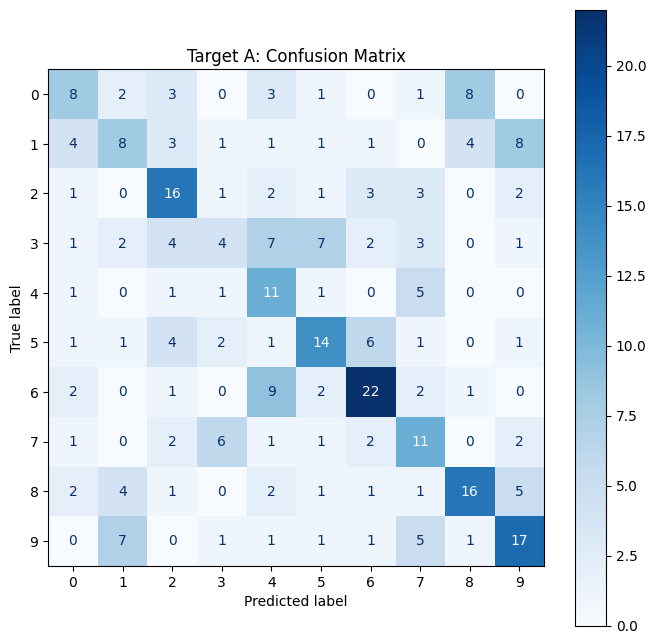


TARGET B (Classes 0-31) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.11      0.14      0.12        14
         1.0       0.00      0.00      0.00        11
         2.0       0.00      0.00      0.00         5
         3.0       0.07      0.18      0.11        11
         4.0       0.00      0.00      0.00        11
         5.0       0.27      0.27      0.27        11
         6.0       0.00      0.00      0.00         6
         7.0       0.00      0.00      0.00         9
         8.0       0.00      0.00      0.00         5
         9.0       0.00      0.00      0.00         9
        10.0       0.00      0.00      0.00        10
        11.0       0.00      0.00      0.00         7
        12.0       0.00      0.00      0.00        11
        13.0       0.11      0.33      0.17         9
        14.0       0.08      0.12      0.10         8
        15.0       0.00      0.00      0.00         6
        16.0       0.04      0.08      0.05 

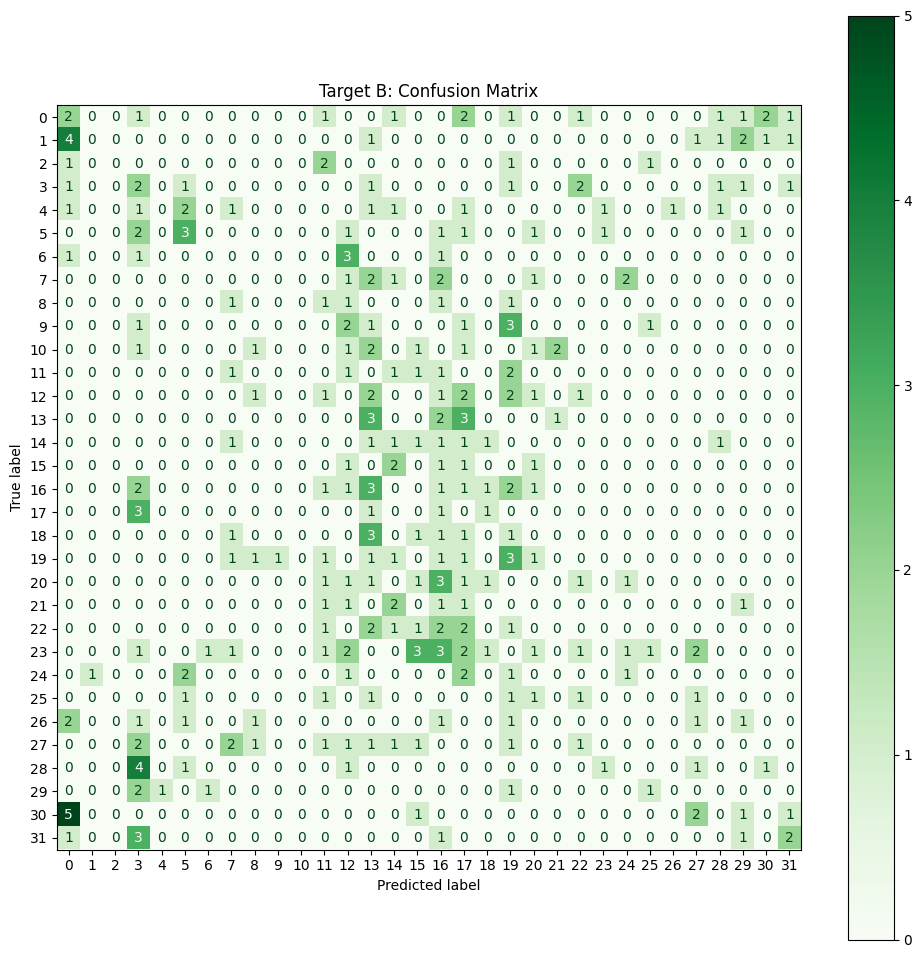


TARGET C (Regression) PERFORMANCE
Mean Absolute Error (MAE): 0.1596


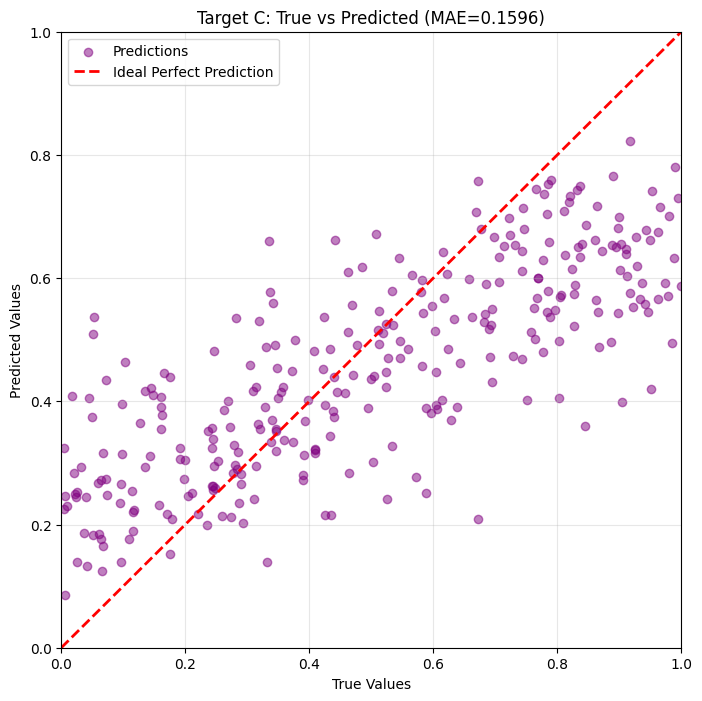

In [250]:
# ==========================================
# 6. EVALUATION & VISUALIZATION
# ==========================================
print("\n--- 4. EVALUATION & PLOTS ---")

# 1. Generate Predictions on Test Set
# We use the predict_fn wrapper which handles shaping/normalization automatically
print("Generating predictions for Test Set...")
val_preds = predict_fn(X_test)

# Extract components from the stacked predictions
# pred_a/b are class indices (integers), pred_c is float
pred_a = val_preds[:, 0].astype(int)
pred_b = val_preds[:, 1].astype(int)
pred_c = val_preds[:, 2]

# --- Target A (Classification 0-9) ---
print("\n" + "=" * 40)
print("TARGET A (Digits 0-9) PERFORMANCE")
print("=" * 40)
print(classification_report(y_test_A, pred_a))

# Plot Confusion Matrix for A
fig_a, ax_a = plt.subplots(figsize=(8, 8))
cm_a = confusion_matrix(y_test_A, pred_a)
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.arange(10))
disp_a.plot(cmap=plt.cm.Blues, ax=ax_a)
ax_a.set_title("Target A: Confusion Matrix")
plt.show()

# --- Target B (Classification 0-31) ---
print("\n" + "=" * 40)
print("TARGET B (Classes 0-31) PERFORMANCE")
print("=" * 40)
# Note: Zero_division=0 handles classes that might not appear in validation set
print(classification_report(y_test_B, pred_b, zero_division=0))

# Plot Confusion Matrix for B
fig_b, ax_b = plt.subplots(figsize=(12, 12))
cm_b = confusion_matrix(y_test_B, pred_b)
# We don't list all 32 labels on axis to keep it clean, or we can just use default ints
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b)
disp_b.plot(cmap=plt.cm.Greens, ax=ax_b, values_format="d")  # 'd' for integers
ax_b.set_title("Target B: Confusion Matrix")
plt.show()

# --- Target C (Regression 0-1) ---
print("\n" + "=" * 40)
print("TARGET C (Regression) PERFORMANCE")
print("=" * 40)
mae_c = mean_absolute_error(y_test_C, pred_c)
print(f"Mean Absolute Error (MAE): {mae_c:.4f}")

# Plot True vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_C, pred_c, alpha=0.5, color="purple", label="Predictions")
plt.plot([0, 1], [0, 1], "r--", linewidth=2, label="Ideal Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Target C: True vs Predicted (MAE={mae_c:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()